# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 12.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 1.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp7 # use or create a database named demo
tweet_collection = db.final_project #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [10]:
count = 100 #number of returned tweets, default and max is 100
geocode = "40.4313473,-80.050541,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [11]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Nov 25 13:08:40 +0000 2020'
'Wed Nov 25 13:07:25 +0000 2020'
'Wed Nov 25 13:07:00 +0000 2020'
'Wed Nov 25 13:05:46 +0000 2020'
'Wed Nov 25 13:05:29 +0000 2020'
'Wed Nov 25 13:05:13 +0000 2020'
'Wed Nov 25 13:04:50 +0000 2020'
'Wed Nov 25 13:04:49 +0000 2020'
'Wed Nov 25 13:03:36 +0000 2020'
'Wed Nov 25 13:03:31 +0000 2020'
'Wed Nov 25 13:03:03 +0000 2020'
'Wed Nov 25 13:01:19 +0000 2020'
'Wed Nov 25 13:00:37 +0000 2020'
'Wed Nov 25 13:00:20 +0000 2020'
'Wed Nov 25 13:00:09 +0000 2020'
'Wed Nov 25 13:00:01 +0000 2020'
'Wed Nov 25 12:57:05 +0000 2020'
'Wed Nov 25 12:52:15 +0000 2020'
'Wed Nov 25 12:48:47 +0000 2020'
'Wed Nov 25 12:46:59 +0000 2020'
'Wed Nov 25 12:45:45 +0000 2020'
'Wed Nov 25 12:45:29 +0000 2020'
'Wed Nov 25 12:42:56 +0000 2020'
'Wed Nov 25 12:42:37 +0000 2020'
'Wed Nov 25 12:38:49 +0000 2020'
'Wed Nov 25 12:38:10 +0000 2020'
'Wed Nov 25 12:37:39 +0000 2020'
'Wed Nov 25 12:37:12 +0000 2020'
'Wed Nov 25 12:35:43 +0000 2020'
'Wed Nov 25 12:35:33 +0000 2020'
'Wed Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [12]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Nov 25 11:30:43 +0000 2020'
'Wed Nov 25 11:26:20 +0000 2020'
'Wed Nov 25 11:25:28 +0000 2020'
'Wed Nov 25 11:25:01 +0000 2020'
'Wed Nov 25 11:22:15 +0000 2020'
'Wed Nov 25 11:20:53 +0000 2020'
'Wed Nov 25 11:20:37 +0000 2020'
'Wed Nov 25 11:20:06 +0000 2020'
'Wed Nov 25 11:19:25 +0000 2020'
'Wed Nov 25 11:18:30 +0000 2020'
'Wed Nov 25 11:17:42 +0000 2020'
'Wed Nov 25 11:17:23 +0000 2020'
'Wed Nov 25 11:17:06 +0000 2020'
'Wed Nov 25 11:13:34 +0000 2020'
'Wed Nov 25 11:10:28 +0000 2020'
'Wed Nov 25 11:04:03 +0000 2020'
'Wed Nov 25 11:03:25 +0000 2020'
'Wed Nov 25 11:01:26 +0000 2020'
'Wed Nov 25 10:56:00 +0000 2020'
'Wed Nov 25 10:54:00 +0000 2020'
'Wed Nov 25 10:48:16 +0000 2020'
'Wed Nov 25 10:48:04 +0000 2020'
'Wed Nov 25 10:47:14 +0000 2020'
'Wed Nov 25 10:41:54 +0000 2020'
'Wed Nov 25 10:40:50 +0000 2020'
'Wed Nov 25 10:32:38 +0000 2020'
'Wed Nov 25 10:30:00 +0000 2020'
'Wed Nov 25 10:27:09 +0000 2020'
'Wed Nov 25 10:24:30 +0000 2020'
'Wed Nov 25 10:23:10 +0000 2020'
'Wed Nov 2

'Wed Nov 25 01:04:22 +0000 2020'
'Wed Nov 25 01:03:07 +0000 2020'
'Wed Nov 25 01:00:03 +0000 2020'
'Wed Nov 25 00:59:51 +0000 2020'
'Wed Nov 25 00:57:21 +0000 2020'
'Wed Nov 25 00:55:08 +0000 2020'
'Wed Nov 25 00:53:22 +0000 2020'
'Wed Nov 25 00:42:39 +0000 2020'
'Wed Nov 25 00:40:17 +0000 2020'
'Wed Nov 25 00:40:01 +0000 2020'
'Wed Nov 25 00:39:57 +0000 2020'
'Wed Nov 25 00:39:43 +0000 2020'
'Wed Nov 25 00:37:01 +0000 2020'
'Wed Nov 25 00:33:01 +0000 2020'
'Wed Nov 25 00:32:35 +0000 2020'
'Wed Nov 25 00:32:18 +0000 2020'
'Wed Nov 25 00:30:52 +0000 2020'
'Wed Nov 25 00:30:47 +0000 2020'
'Wed Nov 25 00:30:19 +0000 2020'
'Wed Nov 25 00:29:04 +0000 2020'
'Wed Nov 25 00:27:55 +0000 2020'
'Wed Nov 25 00:27:32 +0000 2020'
'Wed Nov 25 00:26:37 +0000 2020'
'Wed Nov 25 00:26:19 +0000 2020'
'Wed Nov 25 00:23:44 +0000 2020'
'Wed Nov 25 00:22:31 +0000 2020'
'Wed Nov 25 00:19:57 +0000 2020'
'Wed Nov 25 00:18:12 +0000 2020'
'Wed Nov 25 00:16:43 +0000 2020'
'Wed Nov 25 00:16:06 +0000 2020'
'Wed Nov 2

'Tue Nov 24 20:42:39 +0000 2020'
'Tue Nov 24 20:42:25 +0000 2020'
'Tue Nov 24 20:41:36 +0000 2020'
'Tue Nov 24 20:40:42 +0000 2020'
'Tue Nov 24 20:39:45 +0000 2020'
'Tue Nov 24 20:39:39 +0000 2020'
'Tue Nov 24 20:38:51 +0000 2020'
'Tue Nov 24 20:38:09 +0000 2020'
'Tue Nov 24 20:38:06 +0000 2020'
'Tue Nov 24 20:37:42 +0000 2020'
'Tue Nov 24 20:37:19 +0000 2020'
'Tue Nov 24 20:37:17 +0000 2020'
'Tue Nov 24 20:37:16 +0000 2020'
'Tue Nov 24 20:36:05 +0000 2020'
'Tue Nov 24 20:35:23 +0000 2020'
'Tue Nov 24 20:35:20 +0000 2020'
'Tue Nov 24 20:34:59 +0000 2020'
'Tue Nov 24 20:33:52 +0000 2020'
'Tue Nov 24 20:33:42 +0000 2020'
'Tue Nov 24 20:33:12 +0000 2020'
'Tue Nov 24 20:32:04 +0000 2020'
'Tue Nov 24 20:30:32 +0000 2020'
'Tue Nov 24 20:29:59 +0000 2020'
'Tue Nov 24 20:29:29 +0000 2020'
'Tue Nov 24 20:29:23 +0000 2020'
'Tue Nov 24 20:29:21 +0000 2020'
'Tue Nov 24 20:29:04 +0000 2020'
'Tue Nov 24 20:27:46 +0000 2020'
'Tue Nov 24 20:27:41 +0000 2020'
'Tue Nov 24 20:26:50 +0000 2020'
'Tue Nov 2

'Tue Nov 24 17:18:50 +0000 2020'
'Tue Nov 24 17:18:11 +0000 2020'
'Tue Nov 24 17:18:10 +0000 2020'
'Tue Nov 24 17:17:23 +0000 2020'
'Tue Nov 24 17:13:57 +0000 2020'
'Tue Nov 24 17:13:11 +0000 2020'
'Tue Nov 24 17:12:50 +0000 2020'
'Tue Nov 24 17:12:00 +0000 2020'
'Tue Nov 24 17:07:54 +0000 2020'
'Tue Nov 24 17:06:55 +0000 2020'
'Tue Nov 24 17:03:09 +0000 2020'
'Tue Nov 24 17:02:28 +0000 2020'
'Tue Nov 24 17:02:22 +0000 2020'
'Tue Nov 24 17:01:16 +0000 2020'
'Tue Nov 24 17:00:53 +0000 2020'
'Tue Nov 24 17:00:49 +0000 2020'
'Tue Nov 24 16:59:59 +0000 2020'
'Tue Nov 24 16:52:54 +0000 2020'
'Tue Nov 24 16:52:26 +0000 2020'
'Tue Nov 24 16:50:31 +0000 2020'
'Tue Nov 24 16:47:17 +0000 2020'
'Tue Nov 24 16:46:55 +0000 2020'
'Tue Nov 24 16:43:35 +0000 2020'
'Tue Nov 24 16:43:22 +0000 2020'
'Tue Nov 24 16:43:22 +0000 2020'
'Tue Nov 24 16:43:00 +0000 2020'
'Tue Nov 24 16:42:41 +0000 2020'
'Tue Nov 24 16:39:07 +0000 2020'
'Tue Nov 24 16:38:14 +0000 2020'
'Tue Nov 24 16:35:11 +0000 2020'
'Tue Nov 2

'Tue Nov 24 13:54:03 +0000 2020'
'Tue Nov 24 13:53:04 +0000 2020'
'Tue Nov 24 13:52:32 +0000 2020'
'Tue Nov 24 13:52:06 +0000 2020'
'Tue Nov 24 13:52:04 +0000 2020'
'Tue Nov 24 13:50:59 +0000 2020'
'Tue Nov 24 13:50:37 +0000 2020'
'Tue Nov 24 13:47:47 +0000 2020'
'Tue Nov 24 13:44:44 +0000 2020'
'Tue Nov 24 13:44:21 +0000 2020'
'Tue Nov 24 13:42:56 +0000 2020'
'Tue Nov 24 13:40:49 +0000 2020'
'Tue Nov 24 13:40:49 +0000 2020'
'Tue Nov 24 13:40:36 +0000 2020'
'Tue Nov 24 13:39:56 +0000 2020'
'Tue Nov 24 13:39:41 +0000 2020'
'Tue Nov 24 13:39:24 +0000 2020'
'Tue Nov 24 13:38:45 +0000 2020'
'Tue Nov 24 13:37:06 +0000 2020'
'Tue Nov 24 13:35:20 +0000 2020'
'Tue Nov 24 13:33:44 +0000 2020'
'Tue Nov 24 13:33:33 +0000 2020'
'Tue Nov 24 13:29:49 +0000 2020'
'Tue Nov 24 13:28:35 +0000 2020'
'Tue Nov 24 13:24:38 +0000 2020'
'Tue Nov 24 13:23:06 +0000 2020'
'Tue Nov 24 13:22:52 +0000 2020'
'Tue Nov 24 13:21:08 +0000 2020'
'Tue Nov 24 13:20:01 +0000 2020'
'Tue Nov 24 13:19:28 +0000 2020'
'Tue Nov 2

'Tue Nov 24 05:11:50 +0000 2020'
'Tue Nov 24 05:09:57 +0000 2020'
'Tue Nov 24 05:08:51 +0000 2020'
'Tue Nov 24 05:08:29 +0000 2020'
'Tue Nov 24 05:08:28 +0000 2020'
'Tue Nov 24 05:06:46 +0000 2020'
'Tue Nov 24 05:04:04 +0000 2020'
'Tue Nov 24 05:03:30 +0000 2020'
'Tue Nov 24 05:02:44 +0000 2020'
'Tue Nov 24 04:56:30 +0000 2020'
'Tue Nov 24 04:55:54 +0000 2020'
'Tue Nov 24 04:50:11 +0000 2020'
'Tue Nov 24 04:48:49 +0000 2020'
'Tue Nov 24 04:43:51 +0000 2020'
'Tue Nov 24 04:43:50 +0000 2020'
'Tue Nov 24 04:43:32 +0000 2020'
'Tue Nov 24 04:37:55 +0000 2020'
'Tue Nov 24 04:34:49 +0000 2020'
'Tue Nov 24 04:32:30 +0000 2020'
'Tue Nov 24 04:31:17 +0000 2020'
'Tue Nov 24 04:31:02 +0000 2020'
'Tue Nov 24 04:31:00 +0000 2020'
'Tue Nov 24 04:30:42 +0000 2020'
'Tue Nov 24 04:28:30 +0000 2020'
'Tue Nov 24 04:25:15 +0000 2020'
'Tue Nov 24 04:18:33 +0000 2020'
'Tue Nov 24 04:18:30 +0000 2020'
'Tue Nov 24 04:16:06 +0000 2020'
'Tue Nov 24 04:15:52 +0000 2020'
'Tue Nov 24 04:13:50 +0000 2020'
'Tue Nov 2

'Mon Nov 23 22:49:50 +0000 2020'
'Mon Nov 23 22:49:50 +0000 2020'
'Mon Nov 23 22:49:34 +0000 2020'
'Mon Nov 23 22:49:29 +0000 2020'
'Mon Nov 23 22:49:15 +0000 2020'
'Mon Nov 23 22:48:30 +0000 2020'
'Mon Nov 23 22:47:41 +0000 2020'
'Mon Nov 23 22:45:41 +0000 2020'
'Mon Nov 23 22:45:03 +0000 2020'
'Mon Nov 23 22:43:59 +0000 2020'
'Mon Nov 23 22:43:47 +0000 2020'
'Mon Nov 23 22:43:26 +0000 2020'
'Mon Nov 23 22:42:56 +0000 2020'
'Mon Nov 23 22:42:18 +0000 2020'
'Mon Nov 23 22:40:39 +0000 2020'
'Mon Nov 23 22:39:53 +0000 2020'
'Mon Nov 23 22:39:32 +0000 2020'
'Mon Nov 23 22:39:28 +0000 2020'
'Mon Nov 23 22:38:45 +0000 2020'
'Mon Nov 23 22:37:53 +0000 2020'
'Mon Nov 23 22:37:52 +0000 2020'
'Mon Nov 23 22:36:52 +0000 2020'
'Mon Nov 23 22:36:49 +0000 2020'
'Mon Nov 23 22:36:37 +0000 2020'
'Mon Nov 23 22:36:34 +0000 2020'
'Mon Nov 23 22:35:52 +0000 2020'
'Mon Nov 23 22:35:05 +0000 2020'
'Mon Nov 23 22:34:48 +0000 2020'
'Mon Nov 23 22:34:12 +0000 2020'
'Mon Nov 23 22:34:04 +0000 2020'
'Mon Nov 2

'Mon Nov 23 19:19:01 +0000 2020'
'Mon Nov 23 19:18:46 +0000 2020'
'Mon Nov 23 19:18:44 +0000 2020'
'Mon Nov 23 19:18:35 +0000 2020'
'Mon Nov 23 19:17:29 +0000 2020'
'Mon Nov 23 19:16:41 +0000 2020'
'Mon Nov 23 19:16:33 +0000 2020'
'Mon Nov 23 19:16:04 +0000 2020'
'Mon Nov 23 19:15:04 +0000 2020'
'Mon Nov 23 19:14:43 +0000 2020'
'Mon Nov 23 19:14:37 +0000 2020'
'Mon Nov 23 19:13:54 +0000 2020'
'Mon Nov 23 19:13:28 +0000 2020'
'Mon Nov 23 19:13:26 +0000 2020'
'Mon Nov 23 19:10:39 +0000 2020'
'Mon Nov 23 19:10:37 +0000 2020'
'Mon Nov 23 19:10:32 +0000 2020'
'Mon Nov 23 19:08:10 +0000 2020'
'Mon Nov 23 19:04:00 +0000 2020'
'Mon Nov 23 19:03:46 +0000 2020'
'Mon Nov 23 19:03:07 +0000 2020'
'Mon Nov 23 19:03:04 +0000 2020'
'Mon Nov 23 19:03:04 +0000 2020'
'Mon Nov 23 19:02:47 +0000 2020'
'Mon Nov 23 19:02:39 +0000 2020'
'Mon Nov 23 19:02:32 +0000 2020'
'Mon Nov 23 19:02:27 +0000 2020'
'Mon Nov 23 19:02:22 +0000 2020'
'Mon Nov 23 19:02:15 +0000 2020'
'Mon Nov 23 19:02:10 +0000 2020'
'Mon Nov 2

'Mon Nov 23 16:29:26 +0000 2020'
'Mon Nov 23 16:29:00 +0000 2020'
'Mon Nov 23 16:28:49 +0000 2020'
'Mon Nov 23 16:27:56 +0000 2020'
'Mon Nov 23 16:27:55 +0000 2020'
'Mon Nov 23 16:27:38 +0000 2020'
'Mon Nov 23 16:27:05 +0000 2020'
'Mon Nov 23 16:26:19 +0000 2020'
'Mon Nov 23 16:25:14 +0000 2020'
'Mon Nov 23 16:24:53 +0000 2020'
'Mon Nov 23 16:24:49 +0000 2020'
'Mon Nov 23 16:24:25 +0000 2020'
'Mon Nov 23 16:23:26 +0000 2020'
'Mon Nov 23 16:22:59 +0000 2020'
'Mon Nov 23 16:22:28 +0000 2020'
'Mon Nov 23 16:22:04 +0000 2020'
'Mon Nov 23 16:19:58 +0000 2020'
'Mon Nov 23 16:19:38 +0000 2020'
'Mon Nov 23 16:19:30 +0000 2020'
'Mon Nov 23 16:19:03 +0000 2020'
'Mon Nov 23 16:18:59 +0000 2020'
'Mon Nov 23 16:18:36 +0000 2020'
'Mon Nov 23 16:18:34 +0000 2020'
'Mon Nov 23 16:18:29 +0000 2020'
'Mon Nov 23 16:18:13 +0000 2020'
'Mon Nov 23 16:17:22 +0000 2020'
'Mon Nov 23 16:17:22 +0000 2020'
'Mon Nov 23 16:16:37 +0000 2020'
'Mon Nov 23 16:16:32 +0000 2020'
'Mon Nov 23 16:16:32 +0000 2020'
'Mon Nov 2

'Mon Nov 23 13:30:44 +0000 2020'
'Mon Nov 23 13:29:31 +0000 2020'
'Mon Nov 23 13:29:18 +0000 2020'
'Mon Nov 23 13:28:21 +0000 2020'
'Mon Nov 23 13:27:24 +0000 2020'
'Mon Nov 23 13:21:05 +0000 2020'
'Mon Nov 23 13:20:34 +0000 2020'
'Mon Nov 23 13:19:58 +0000 2020'
'Mon Nov 23 13:19:19 +0000 2020'
'Mon Nov 23 13:16:41 +0000 2020'
'Mon Nov 23 13:16:26 +0000 2020'
'Mon Nov 23 13:16:03 +0000 2020'
'Mon Nov 23 13:15:48 +0000 2020'
'Mon Nov 23 13:13:59 +0000 2020'
'Mon Nov 23 13:13:53 +0000 2020'
'Mon Nov 23 13:13:45 +0000 2020'
'Mon Nov 23 13:13:28 +0000 2020'
'Mon Nov 23 13:13:20 +0000 2020'
'Mon Nov 23 13:11:33 +0000 2020'
'Mon Nov 23 13:11:30 +0000 2020'
'Mon Nov 23 13:09:57 +0000 2020'
'Mon Nov 23 13:07:52 +0000 2020'
'Mon Nov 23 13:05:01 +0000 2020'
'Mon Nov 23 13:04:54 +0000 2020'
'Mon Nov 23 13:04:37 +0000 2020'
'Mon Nov 23 13:04:00 +0000 2020'
'Mon Nov 23 13:03:35 +0000 2020'
'Mon Nov 23 13:02:00 +0000 2020'
'Mon Nov 23 13:01:15 +0000 2020'
'Mon Nov 23 13:00:58 +0000 2020'
'Mon Nov 2

'Mon Nov 23 05:03:51 +0000 2020'
'Mon Nov 23 05:02:47 +0000 2020'
'Mon Nov 23 04:58:51 +0000 2020'
'Mon Nov 23 04:58:21 +0000 2020'
'Mon Nov 23 04:55:24 +0000 2020'
'Mon Nov 23 04:53:21 +0000 2020'
'Mon Nov 23 04:51:50 +0000 2020'
'Mon Nov 23 04:51:30 +0000 2020'
'Mon Nov 23 04:49:14 +0000 2020'
'Mon Nov 23 04:44:07 +0000 2020'
'Mon Nov 23 04:43:24 +0000 2020'
'Mon Nov 23 04:33:21 +0000 2020'
'Mon Nov 23 04:32:24 +0000 2020'
'Mon Nov 23 04:30:34 +0000 2020'
'Mon Nov 23 04:28:46 +0000 2020'
'Mon Nov 23 04:25:42 +0000 2020'
'Mon Nov 23 04:24:22 +0000 2020'
'Mon Nov 23 04:24:00 +0000 2020'
'Mon Nov 23 04:23:23 +0000 2020'
'Mon Nov 23 04:22:33 +0000 2020'
'Mon Nov 23 04:22:00 +0000 2020'
'Mon Nov 23 04:21:26 +0000 2020'
'Mon Nov 23 04:19:22 +0000 2020'
'Mon Nov 23 04:16:15 +0000 2020'
'Mon Nov 23 04:09:54 +0000 2020'
'Mon Nov 23 04:08:51 +0000 2020'
'Mon Nov 23 04:08:15 +0000 2020'
'Mon Nov 23 04:07:34 +0000 2020'
'Mon Nov 23 04:07:02 +0000 2020'
'Mon Nov 23 04:05:12 +0000 2020'
'Mon Nov 2

'Sun Nov 22 23:14:55 +0000 2020'
'Sun Nov 22 23:13:04 +0000 2020'
'Sun Nov 22 23:10:04 +0000 2020'
'Sun Nov 22 23:07:18 +0000 2020'
'Sun Nov 22 23:06:25 +0000 2020'
'Sun Nov 22 23:06:14 +0000 2020'
'Sun Nov 22 23:05:21 +0000 2020'
'Sun Nov 22 23:04:25 +0000 2020'
'Sun Nov 22 23:04:22 +0000 2020'
'Sun Nov 22 23:02:27 +0000 2020'
'Sun Nov 22 23:01:54 +0000 2020'
'Sun Nov 22 23:00:06 +0000 2020'
'Sun Nov 22 23:00:04 +0000 2020'
'Sun Nov 22 22:55:59 +0000 2020'
'Sun Nov 22 22:55:49 +0000 2020'
'Sun Nov 22 22:54:50 +0000 2020'
'Sun Nov 22 22:53:28 +0000 2020'
'Sun Nov 22 22:52:52 +0000 2020'
'Sun Nov 22 22:52:36 +0000 2020'
'Sun Nov 22 22:51:57 +0000 2020'
'Sun Nov 22 22:51:32 +0000 2020'
'Sun Nov 22 22:48:11 +0000 2020'
'Sun Nov 22 22:45:09 +0000 2020'
'Sun Nov 22 22:43:32 +0000 2020'
'Sun Nov 22 22:43:17 +0000 2020'
'Sun Nov 22 22:43:07 +0000 2020'
'Sun Nov 22 22:42:13 +0000 2020'
'Sun Nov 22 22:41:56 +0000 2020'
'Sun Nov 22 22:41:51 +0000 2020'
'Sun Nov 22 22:40:27 +0000 2020'
'Sun Nov 2

'Sun Nov 22 19:07:50 +0000 2020'
'Sun Nov 22 19:07:17 +0000 2020'
'Sun Nov 22 19:05:34 +0000 2020'
'Sun Nov 22 19:05:01 +0000 2020'
'Sun Nov 22 19:04:58 +0000 2020'
'Sun Nov 22 19:04:02 +0000 2020'
'Sun Nov 22 19:02:01 +0000 2020'
'Sun Nov 22 19:00:22 +0000 2020'
'Sun Nov 22 19:00:00 +0000 2020'
'Sun Nov 22 18:59:55 +0000 2020'
'Sun Nov 22 18:58:37 +0000 2020'
'Sun Nov 22 18:56:38 +0000 2020'
'Sun Nov 22 18:56:21 +0000 2020'
'Sun Nov 22 18:56:03 +0000 2020'
'Sun Nov 22 18:55:29 +0000 2020'
'Sun Nov 22 18:53:52 +0000 2020'
'Sun Nov 22 18:53:26 +0000 2020'
'Sun Nov 22 18:53:15 +0000 2020'
'Sun Nov 22 18:51:50 +0000 2020'
'Sun Nov 22 18:50:50 +0000 2020'
'Sun Nov 22 18:50:41 +0000 2020'
'Sun Nov 22 18:49:32 +0000 2020'
'Sun Nov 22 18:48:18 +0000 2020'
'Sun Nov 22 18:48:07 +0000 2020'
'Sun Nov 22 18:46:25 +0000 2020'
'Sun Nov 22 18:45:28 +0000 2020'
'Sun Nov 22 18:45:14 +0000 2020'
'Sun Nov 22 18:44:33 +0000 2020'
'Sun Nov 22 18:44:04 +0000 2020'
'Sun Nov 22 18:43:55 +0000 2020'
'Sun Nov 2

'Sun Nov 22 14:23:04 +0000 2020'
'Sun Nov 22 14:21:54 +0000 2020'
'Sun Nov 22 14:21:11 +0000 2020'
'Sun Nov 22 14:21:09 +0000 2020'
'Sun Nov 22 14:17:54 +0000 2020'
'Sun Nov 22 14:17:08 +0000 2020'
'Sun Nov 22 14:16:30 +0000 2020'
'Sun Nov 22 14:15:17 +0000 2020'
'Sun Nov 22 14:15:11 +0000 2020'
'Sun Nov 22 14:13:55 +0000 2020'
'Sun Nov 22 14:13:44 +0000 2020'
'Sun Nov 22 14:13:32 +0000 2020'
'Sun Nov 22 14:13:23 +0000 2020'
'Sun Nov 22 14:09:06 +0000 2020'
'Sun Nov 22 14:08:46 +0000 2020'
'Sun Nov 22 14:06:35 +0000 2020'
'Sun Nov 22 14:03:00 +0000 2020'
'Sun Nov 22 14:02:50 +0000 2020'
'Sun Nov 22 14:02:29 +0000 2020'
'Sun Nov 22 14:01:47 +0000 2020'
'Sun Nov 22 14:00:15 +0000 2020'
'Sun Nov 22 13:58:41 +0000 2020'
'Sun Nov 22 13:57:49 +0000 2020'
'Sun Nov 22 13:55:05 +0000 2020'
'Sun Nov 22 13:53:50 +0000 2020'
'Sun Nov 22 13:52:20 +0000 2020'
'Sun Nov 22 13:52:03 +0000 2020'
'Sun Nov 22 13:47:32 +0000 2020'
'Sun Nov 22 13:44:15 +0000 2020'
'Sun Nov 22 13:42:13 +0000 2020'
'Sun Nov 2

'Sun Nov 22 07:58:34 +0000 2020'
'Sun Nov 22 07:57:12 +0000 2020'
'Sun Nov 22 07:57:05 +0000 2020'
'Sun Nov 22 07:57:02 +0000 2020'
'Sun Nov 22 07:55:32 +0000 2020'
'Sun Nov 22 07:55:19 +0000 2020'
'Sun Nov 22 07:54:11 +0000 2020'
'Sun Nov 22 07:54:06 +0000 2020'
'Sun Nov 22 07:52:03 +0000 2020'
'Sun Nov 22 07:51:24 +0000 2020'
'Sun Nov 22 07:51:17 +0000 2020'
'Sun Nov 22 07:49:52 +0000 2020'
'Sun Nov 22 07:49:50 +0000 2020'
'Sun Nov 22 07:49:06 +0000 2020'
'Sun Nov 22 07:48:26 +0000 2020'
'Sun Nov 22 07:47:58 +0000 2020'
'Sun Nov 22 07:47:30 +0000 2020'
'Sun Nov 22 07:46:46 +0000 2020'
'Sun Nov 22 07:46:37 +0000 2020'
'Sun Nov 22 07:45:26 +0000 2020'
'Sun Nov 22 07:45:22 +0000 2020'
'Sun Nov 22 07:45:02 +0000 2020'
'Sun Nov 22 07:44:09 +0000 2020'
'Sun Nov 22 07:44:04 +0000 2020'
'Sun Nov 22 07:43:25 +0000 2020'
'Sun Nov 22 07:41:59 +0000 2020'
'Sun Nov 22 07:35:49 +0000 2020'
'Sun Nov 22 07:35:06 +0000 2020'
'Sun Nov 22 07:32:31 +0000 2020'
'Sun Nov 22 07:32:24 +0000 2020'
'Sun Nov 2

'Sun Nov 22 00:42:27 +0000 2020'
'Sun Nov 22 00:42:23 +0000 2020'
'Sun Nov 22 00:41:47 +0000 2020'
'Sun Nov 22 00:40:54 +0000 2020'
'Sun Nov 22 00:39:54 +0000 2020'
'Sun Nov 22 00:37:44 +0000 2020'
'Sun Nov 22 00:36:29 +0000 2020'
'Sun Nov 22 00:31:32 +0000 2020'
'Sun Nov 22 00:29:35 +0000 2020'
'Sun Nov 22 00:28:54 +0000 2020'
'Sun Nov 22 00:27:32 +0000 2020'
'Sun Nov 22 00:25:13 +0000 2020'
'Sun Nov 22 00:24:48 +0000 2020'
'Sun Nov 22 00:21:32 +0000 2020'
'Sun Nov 22 00:15:32 +0000 2020'
'Sun Nov 22 00:15:00 +0000 2020'
'Sun Nov 22 00:10:41 +0000 2020'
'Sun Nov 22 00:10:38 +0000 2020'
'Sun Nov 22 00:10:02 +0000 2020'
'Sun Nov 22 00:08:17 +0000 2020'
'Sun Nov 22 00:06:10 +0000 2020'
'Sun Nov 22 00:05:24 +0000 2020'
'Sun Nov 22 00:00:58 +0000 2020'
'Sat Nov 21 23:59:35 +0000 2020'
'Sat Nov 21 23:59:20 +0000 2020'
'Sat Nov 21 23:59:01 +0000 2020'
'Sat Nov 21 23:53:55 +0000 2020'
'Sat Nov 21 23:52:18 +0000 2020'
'Sat Nov 21 23:50:47 +0000 2020'
'Sat Nov 21 23:47:27 +0000 2020'
'Sat Nov 2

'Sat Nov 21 19:44:04 +0000 2020'
'Sat Nov 21 19:43:44 +0000 2020'
'Sat Nov 21 19:43:42 +0000 2020'
'Sat Nov 21 19:43:38 +0000 2020'
'Sat Nov 21 19:43:35 +0000 2020'
'Sat Nov 21 19:43:04 +0000 2020'
'Sat Nov 21 19:43:00 +0000 2020'
'Sat Nov 21 19:42:33 +0000 2020'
'Sat Nov 21 19:42:33 +0000 2020'
'Sat Nov 21 19:39:32 +0000 2020'
'Sat Nov 21 19:38:01 +0000 2020'
'Sat Nov 21 19:37:19 +0000 2020'
'Sat Nov 21 19:37:18 +0000 2020'
'Sat Nov 21 19:36:22 +0000 2020'
'Sat Nov 21 19:33:33 +0000 2020'
'Sat Nov 21 19:32:38 +0000 2020'
'Sat Nov 21 19:30:19 +0000 2020'
'Sat Nov 21 19:30:17 +0000 2020'
'Sat Nov 21 19:29:49 +0000 2020'
'Sat Nov 21 19:29:45 +0000 2020'
'Sat Nov 21 19:29:08 +0000 2020'
'Sat Nov 21 19:28:59 +0000 2020'
'Sat Nov 21 19:28:51 +0000 2020'
'Sat Nov 21 19:28:46 +0000 2020'
'Sat Nov 21 19:28:28 +0000 2020'
'Sat Nov 21 19:26:28 +0000 2020'
'Sat Nov 21 19:26:05 +0000 2020'
'Sat Nov 21 19:24:18 +0000 2020'
'Sat Nov 21 19:23:04 +0000 2020'
'Sat Nov 21 19:21:28 +0000 2020'
'Sat Nov 2

'Sat Nov 21 16:06:01 +0000 2020'
'Sat Nov 21 16:05:22 +0000 2020'
'Sat Nov 21 16:05:05 +0000 2020'
'Sat Nov 21 16:04:45 +0000 2020'
'Sat Nov 21 16:04:25 +0000 2020'
'Sat Nov 21 16:00:50 +0000 2020'
'Sat Nov 21 16:00:20 +0000 2020'
'Sat Nov 21 16:00:11 +0000 2020'
'Sat Nov 21 15:58:06 +0000 2020'
'Sat Nov 21 15:57:49 +0000 2020'
'Sat Nov 21 15:57:25 +0000 2020'
'Sat Nov 21 15:57:16 +0000 2020'
'Sat Nov 21 15:57:02 +0000 2020'
'Sat Nov 21 15:56:56 +0000 2020'
'Sat Nov 21 15:56:46 +0000 2020'
'Sat Nov 21 15:56:41 +0000 2020'
'Sat Nov 21 15:56:25 +0000 2020'
'Sat Nov 21 15:56:06 +0000 2020'
'Sat Nov 21 15:55:35 +0000 2020'
'Sat Nov 21 15:54:38 +0000 2020'
'Sat Nov 21 15:54:17 +0000 2020'
'Sat Nov 21 15:53:54 +0000 2020'
'Sat Nov 21 15:53:01 +0000 2020'
'Sat Nov 21 15:52:31 +0000 2020'
'Sat Nov 21 15:52:26 +0000 2020'
'Sat Nov 21 15:50:35 +0000 2020'
'Sat Nov 21 15:50:20 +0000 2020'
'Sat Nov 21 15:50:13 +0000 2020'
'Sat Nov 21 15:49:45 +0000 2020'
'Sat Nov 21 15:49:04 +0000 2020'
'Sat Nov 2

'Sat Nov 21 13:06:19 +0000 2020'
'Sat Nov 21 13:05:28 +0000 2020'
'Sat Nov 21 13:04:39 +0000 2020'
'Sat Nov 21 13:04:33 +0000 2020'
'Sat Nov 21 13:04:08 +0000 2020'
'Sat Nov 21 13:02:35 +0000 2020'
'Sat Nov 21 13:01:45 +0000 2020'
'Sat Nov 21 13:00:57 +0000 2020'
'Sat Nov 21 13:00:34 +0000 2020'
'Sat Nov 21 13:00:07 +0000 2020'
'Sat Nov 21 12:57:49 +0000 2020'
'Sat Nov 21 12:57:32 +0000 2020'
'Sat Nov 21 12:57:30 +0000 2020'
'Sat Nov 21 12:56:03 +0000 2020'
'Sat Nov 21 12:54:35 +0000 2020'
'Sat Nov 21 12:53:57 +0000 2020'
'Sat Nov 21 12:53:46 +0000 2020'
'Sat Nov 21 12:53:29 +0000 2020'
'Sat Nov 21 12:53:16 +0000 2020'
'Sat Nov 21 12:52:35 +0000 2020'
'Sat Nov 21 12:52:21 +0000 2020'
'Sat Nov 21 12:49:39 +0000 2020'
'Sat Nov 21 12:49:32 +0000 2020'
'Sat Nov 21 12:49:31 +0000 2020'
'Sat Nov 21 12:49:30 +0000 2020'
'Sat Nov 21 12:49:09 +0000 2020'
'Sat Nov 21 12:47:54 +0000 2020'
'Sat Nov 21 12:47:35 +0000 2020'
'Sat Nov 21 12:46:28 +0000 2020'
'Sat Nov 21 12:46:19 +0000 2020'
'Sat Nov 2

'Sat Nov 21 08:34:44 +0000 2020'
'Sat Nov 21 08:34:16 +0000 2020'
'Sat Nov 21 08:30:57 +0000 2020'
'Sat Nov 21 08:27:54 +0000 2020'
'Sat Nov 21 08:27:44 +0000 2020'
'Sat Nov 21 08:26:26 +0000 2020'
'Sat Nov 21 08:23:46 +0000 2020'
'Sat Nov 21 08:23:21 +0000 2020'
'Sat Nov 21 08:21:48 +0000 2020'
'Sat Nov 21 08:20:39 +0000 2020'
'Sat Nov 21 08:11:35 +0000 2020'
'Sat Nov 21 08:03:02 +0000 2020'
'Sat Nov 21 08:01:33 +0000 2020'
'Sat Nov 21 07:57:48 +0000 2020'
'Sat Nov 21 07:57:20 +0000 2020'
'Sat Nov 21 07:57:09 +0000 2020'
'Sat Nov 21 07:55:39 +0000 2020'
'Sat Nov 21 07:55:11 +0000 2020'
'Sat Nov 21 07:51:05 +0000 2020'
'Sat Nov 21 07:50:55 +0000 2020'
'Sat Nov 21 07:49:38 +0000 2020'
'Sat Nov 21 07:48:15 +0000 2020'
'Sat Nov 21 07:41:55 +0000 2020'
'Sat Nov 21 07:41:32 +0000 2020'
'Sat Nov 21 07:33:09 +0000 2020'
'Sat Nov 21 07:32:02 +0000 2020'
'Sat Nov 21 07:32:02 +0000 2020'
'Sat Nov 21 07:31:21 +0000 2020'
'Sat Nov 21 07:30:24 +0000 2020'
'Sat Nov 21 07:30:00 +0000 2020'
'Sat Nov 2

'Sat Nov 21 00:45:52 +0000 2020'
'Sat Nov 21 00:44:32 +0000 2020'
'Sat Nov 21 00:44:27 +0000 2020'
'Sat Nov 21 00:44:14 +0000 2020'
'Sat Nov 21 00:44:13 +0000 2020'
'Sat Nov 21 00:44:01 +0000 2020'
'Sat Nov 21 00:43:48 +0000 2020'
'Sat Nov 21 00:42:33 +0000 2020'
'Sat Nov 21 00:41:23 +0000 2020'
'Sat Nov 21 00:40:42 +0000 2020'
'Sat Nov 21 00:40:35 +0000 2020'
'Sat Nov 21 00:40:00 +0000 2020'
'Sat Nov 21 00:39:04 +0000 2020'
'Sat Nov 21 00:38:19 +0000 2020'
'Sat Nov 21 00:37:55 +0000 2020'
'Sat Nov 21 00:37:06 +0000 2020'
'Sat Nov 21 00:36:50 +0000 2020'
'Sat Nov 21 00:36:09 +0000 2020'
'Sat Nov 21 00:35:33 +0000 2020'
'Sat Nov 21 00:35:31 +0000 2020'
'Sat Nov 21 00:34:30 +0000 2020'
'Sat Nov 21 00:33:48 +0000 2020'
'Sat Nov 21 00:33:38 +0000 2020'
'Sat Nov 21 00:33:01 +0000 2020'
'Sat Nov 21 00:32:15 +0000 2020'
'Sat Nov 21 00:32:07 +0000 2020'
'Sat Nov 21 00:31:55 +0000 2020'
'Sat Nov 21 00:29:08 +0000 2020'
'Sat Nov 21 00:28:38 +0000 2020'
'Sat Nov 21 00:28:19 +0000 2020'
'Sat Nov 2

'Fri Nov 20 21:31:34 +0000 2020'
'Fri Nov 20 21:31:24 +0000 2020'
'Fri Nov 20 21:30:20 +0000 2020'
'Fri Nov 20 21:30:00 +0000 2020'
'Fri Nov 20 21:29:24 +0000 2020'
'Fri Nov 20 21:29:21 +0000 2020'
'Fri Nov 20 21:28:15 +0000 2020'
'Fri Nov 20 21:28:12 +0000 2020'
'Fri Nov 20 21:27:51 +0000 2020'
'Fri Nov 20 21:27:22 +0000 2020'
'Fri Nov 20 21:26:45 +0000 2020'
'Fri Nov 20 21:26:29 +0000 2020'
'Fri Nov 20 21:24:29 +0000 2020'
'Fri Nov 20 21:23:23 +0000 2020'
'Fri Nov 20 21:22:21 +0000 2020'
'Fri Nov 20 21:22:00 +0000 2020'
'Fri Nov 20 21:21:44 +0000 2020'
'Fri Nov 20 21:21:39 +0000 2020'
'Fri Nov 20 21:21:28 +0000 2020'
'Fri Nov 20 21:21:16 +0000 2020'
'Fri Nov 20 21:21:01 +0000 2020'
'Fri Nov 20 21:20:59 +0000 2020'
'Fri Nov 20 21:19:42 +0000 2020'
'Fri Nov 20 21:19:41 +0000 2020'
'Fri Nov 20 21:18:53 +0000 2020'
'Fri Nov 20 21:18:32 +0000 2020'
'Fri Nov 20 21:18:22 +0000 2020'
'Fri Nov 20 21:17:56 +0000 2020'
'Fri Nov 20 21:17:49 +0000 2020'
'Fri Nov 20 21:17:08 +0000 2020'
'Fri Nov 2

'Fri Nov 20 18:36:43 +0000 2020'
'Fri Nov 20 18:36:26 +0000 2020'
'Fri Nov 20 18:34:41 +0000 2020'
'Fri Nov 20 18:33:08 +0000 2020'
'Fri Nov 20 18:32:23 +0000 2020'
'Fri Nov 20 18:32:11 +0000 2020'
'Fri Nov 20 18:31:32 +0000 2020'
'Fri Nov 20 18:30:51 +0000 2020'
'Fri Nov 20 18:30:47 +0000 2020'
'Fri Nov 20 18:30:19 +0000 2020'
'Fri Nov 20 18:30:06 +0000 2020'
'Fri Nov 20 18:29:45 +0000 2020'
'Fri Nov 20 18:29:29 +0000 2020'
'Fri Nov 20 18:29:08 +0000 2020'
'Fri Nov 20 18:27:18 +0000 2020'
'Fri Nov 20 18:27:05 +0000 2020'
'Fri Nov 20 18:25:56 +0000 2020'
'Fri Nov 20 18:22:18 +0000 2020'
'Fri Nov 20 18:20:16 +0000 2020'
'Fri Nov 20 18:17:54 +0000 2020'
'Fri Nov 20 18:17:04 +0000 2020'
'Fri Nov 20 18:17:02 +0000 2020'
'Fri Nov 20 18:16:06 +0000 2020'
'Fri Nov 20 18:13:53 +0000 2020'
'Fri Nov 20 18:13:43 +0000 2020'
'Fri Nov 20 18:11:44 +0000 2020'
'Fri Nov 20 18:10:25 +0000 2020'
'Fri Nov 20 18:10:08 +0000 2020'
'Fri Nov 20 18:10:07 +0000 2020'
'Fri Nov 20 18:09:43 +0000 2020'
'Fri Nov 2

'Fri Nov 20 15:55:46 +0000 2020'
'Fri Nov 20 15:55:39 +0000 2020'
'Fri Nov 20 15:52:36 +0000 2020'
'Fri Nov 20 15:52:20 +0000 2020'
'Fri Nov 20 15:50:57 +0000 2020'
'Fri Nov 20 15:50:21 +0000 2020'
'Fri Nov 20 15:49:38 +0000 2020'
'Fri Nov 20 15:46:19 +0000 2020'
'Fri Nov 20 15:45:19 +0000 2020'
'Fri Nov 20 15:44:49 +0000 2020'
'Fri Nov 20 15:44:45 +0000 2020'
'Fri Nov 20 15:44:45 +0000 2020'
'Fri Nov 20 15:43:23 +0000 2020'
'Fri Nov 20 15:43:14 +0000 2020'
'Fri Nov 20 15:42:43 +0000 2020'
'Fri Nov 20 15:41:39 +0000 2020'
'Fri Nov 20 15:41:25 +0000 2020'
'Fri Nov 20 15:40:37 +0000 2020'
'Fri Nov 20 15:40:10 +0000 2020'
'Fri Nov 20 15:39:13 +0000 2020'
'Fri Nov 20 15:39:00 +0000 2020'
'Fri Nov 20 15:38:24 +0000 2020'
'Fri Nov 20 15:37:27 +0000 2020'
'Fri Nov 20 15:37:22 +0000 2020'
'Fri Nov 20 15:36:27 +0000 2020'
'Fri Nov 20 15:36:21 +0000 2020'
'Fri Nov 20 15:36:05 +0000 2020'
'Fri Nov 20 15:35:52 +0000 2020'
'Fri Nov 20 15:35:26 +0000 2020'
'Fri Nov 20 15:34:56 +0000 2020'
'Fri Nov 2

'Fri Nov 20 13:40:23 +0000 2020'
'Fri Nov 20 13:40:05 +0000 2020'
'Fri Nov 20 13:38:13 +0000 2020'
'Fri Nov 20 13:36:00 +0000 2020'
'Fri Nov 20 13:35:56 +0000 2020'
'Fri Nov 20 13:35:16 +0000 2020'
'Fri Nov 20 13:32:36 +0000 2020'
'Fri Nov 20 13:32:09 +0000 2020'
'Fri Nov 20 13:32:04 +0000 2020'
'Fri Nov 20 13:30:34 +0000 2020'
'Fri Nov 20 13:30:18 +0000 2020'
'Fri Nov 20 13:30:08 +0000 2020'
'Fri Nov 20 13:29:28 +0000 2020'
'Fri Nov 20 13:29:20 +0000 2020'
'Fri Nov 20 13:29:08 +0000 2020'
'Fri Nov 20 13:27:10 +0000 2020'
'Fri Nov 20 13:26:51 +0000 2020'
'Fri Nov 20 13:26:38 +0000 2020'
'Fri Nov 20 13:26:02 +0000 2020'
'Fri Nov 20 13:25:20 +0000 2020'
'Fri Nov 20 13:25:20 +0000 2020'
'Fri Nov 20 13:23:55 +0000 2020'
'Fri Nov 20 13:23:52 +0000 2020'
'Fri Nov 20 13:23:32 +0000 2020'
'Fri Nov 20 13:21:15 +0000 2020'
'Fri Nov 20 13:20:29 +0000 2020'
'Fri Nov 20 13:19:47 +0000 2020'
'Fri Nov 20 13:18:11 +0000 2020'
'Fri Nov 20 13:17:43 +0000 2020'
'Fri Nov 20 13:16:30 +0000 2020'
'Fri Nov 2

'Fri Nov 20 07:48:25 +0000 2020'
'Fri Nov 20 07:48:02 +0000 2020'
'Fri Nov 20 07:44:58 +0000 2020'
'Fri Nov 20 07:43:16 +0000 2020'
'Fri Nov 20 07:40:31 +0000 2020'
'Fri Nov 20 07:39:48 +0000 2020'
'Fri Nov 20 07:39:14 +0000 2020'
'Fri Nov 20 07:35:16 +0000 2020'
'Fri Nov 20 07:35:02 +0000 2020'
'Fri Nov 20 07:34:19 +0000 2020'
'Fri Nov 20 07:34:06 +0000 2020'
'Fri Nov 20 07:33:35 +0000 2020'
'Fri Nov 20 07:33:08 +0000 2020'
'Fri Nov 20 07:32:27 +0000 2020'
'Fri Nov 20 07:31:57 +0000 2020'
'Fri Nov 20 07:28:01 +0000 2020'
'Fri Nov 20 07:27:13 +0000 2020'
'Fri Nov 20 07:26:32 +0000 2020'
'Fri Nov 20 07:25:44 +0000 2020'
'Fri Nov 20 07:25:40 +0000 2020'
'Fri Nov 20 07:22:48 +0000 2020'
'Fri Nov 20 07:21:12 +0000 2020'
'Fri Nov 20 07:20:30 +0000 2020'
'Fri Nov 20 07:19:58 +0000 2020'
'Fri Nov 20 07:17:42 +0000 2020'
'Fri Nov 20 07:12:54 +0000 2020'
'Fri Nov 20 07:11:27 +0000 2020'
'Fri Nov 20 07:10:19 +0000 2020'
'Fri Nov 20 07:10:10 +0000 2020'
'Fri Nov 20 07:08:10 +0000 2020'
'Fri Nov 2

'Fri Nov 20 02:20:06 +0000 2020'
'Fri Nov 20 02:18:41 +0000 2020'
'Fri Nov 20 02:16:42 +0000 2020'
'Fri Nov 20 02:14:47 +0000 2020'
'Fri Nov 20 02:11:03 +0000 2020'
'Fri Nov 20 02:10:25 +0000 2020'
'Fri Nov 20 02:10:02 +0000 2020'
'Fri Nov 20 02:09:37 +0000 2020'
'Fri Nov 20 02:08:47 +0000 2020'
'Fri Nov 20 02:08:45 +0000 2020'
'Fri Nov 20 02:08:42 +0000 2020'
'Fri Nov 20 02:08:40 +0000 2020'
'Fri Nov 20 02:08:10 +0000 2020'
'Fri Nov 20 02:07:04 +0000 2020'
'Fri Nov 20 02:06:00 +0000 2020'
'Fri Nov 20 02:05:45 +0000 2020'
'Fri Nov 20 02:05:45 +0000 2020'
'Fri Nov 20 02:05:22 +0000 2020'
'Fri Nov 20 02:05:07 +0000 2020'
'Fri Nov 20 02:05:03 +0000 2020'
'Fri Nov 20 02:04:40 +0000 2020'
'Fri Nov 20 02:03:49 +0000 2020'
'Fri Nov 20 02:03:17 +0000 2020'
'Fri Nov 20 02:02:48 +0000 2020'
'Fri Nov 20 02:02:32 +0000 2020'
'Fri Nov 20 02:01:44 +0000 2020'
'Fri Nov 20 02:01:05 +0000 2020'
'Fri Nov 20 01:59:44 +0000 2020'
'Fri Nov 20 01:57:54 +0000 2020'
'Fri Nov 20 01:57:28 +0000 2020'
'Fri Nov 2

'Thu Nov 19 22:58:14 +0000 2020'
'Thu Nov 19 22:57:58 +0000 2020'
'Thu Nov 19 22:57:53 +0000 2020'
'Thu Nov 19 22:54:43 +0000 2020'
'Thu Nov 19 22:54:16 +0000 2020'
'Thu Nov 19 22:54:13 +0000 2020'
'Thu Nov 19 22:54:00 +0000 2020'
'Thu Nov 19 22:52:41 +0000 2020'
'Thu Nov 19 22:51:47 +0000 2020'
'Thu Nov 19 22:51:14 +0000 2020'
'Thu Nov 19 22:50:21 +0000 2020'
'Thu Nov 19 22:50:09 +0000 2020'
'Thu Nov 19 22:49:54 +0000 2020'
'Thu Nov 19 22:49:01 +0000 2020'
'Thu Nov 19 22:48:46 +0000 2020'
'Thu Nov 19 22:47:58 +0000 2020'
'Thu Nov 19 22:47:28 +0000 2020'
'Thu Nov 19 22:46:55 +0000 2020'
'Thu Nov 19 22:46:54 +0000 2020'
'Thu Nov 19 22:46:21 +0000 2020'
'Thu Nov 19 22:46:08 +0000 2020'
'Thu Nov 19 22:46:01 +0000 2020'
'Thu Nov 19 22:45:53 +0000 2020'
'Thu Nov 19 22:45:40 +0000 2020'
'Thu Nov 19 22:45:31 +0000 2020'
'Thu Nov 19 22:45:23 +0000 2020'
'Thu Nov 19 22:45:21 +0000 2020'
'Thu Nov 19 22:45:17 +0000 2020'
'Thu Nov 19 22:44:37 +0000 2020'
'Thu Nov 19 22:44:24 +0000 2020'
'Thu Nov 1

'Thu Nov 19 21:04:46 +0000 2020'
'Thu Nov 19 21:04:37 +0000 2020'
'Thu Nov 19 21:04:35 +0000 2020'
'Thu Nov 19 21:04:31 +0000 2020'
'Thu Nov 19 21:04:09 +0000 2020'
'Thu Nov 19 21:04:08 +0000 2020'
'Thu Nov 19 21:04:03 +0000 2020'
'Thu Nov 19 21:04:02 +0000 2020'
'Thu Nov 19 21:03:58 +0000 2020'
'Thu Nov 19 21:03:55 +0000 2020'
'Thu Nov 19 21:03:43 +0000 2020'
'Thu Nov 19 21:03:31 +0000 2020'
'Thu Nov 19 21:03:23 +0000 2020'
'Thu Nov 19 21:02:55 +0000 2020'
'Thu Nov 19 21:01:33 +0000 2020'
'Thu Nov 19 21:01:30 +0000 2020'
'Thu Nov 19 21:01:22 +0000 2020'
'Thu Nov 19 21:01:01 +0000 2020'
'Thu Nov 19 21:00:57 +0000 2020'
'Thu Nov 19 21:00:41 +0000 2020'
'Thu Nov 19 21:00:40 +0000 2020'
'Thu Nov 19 21:00:34 +0000 2020'
'Thu Nov 19 21:00:34 +0000 2020'
'Thu Nov 19 21:00:27 +0000 2020'
'Thu Nov 19 21:00:27 +0000 2020'
'Thu Nov 19 21:00:19 +0000 2020'
'Thu Nov 19 21:00:17 +0000 2020'
'Thu Nov 19 21:00:12 +0000 2020'
'Thu Nov 19 21:00:01 +0000 2020'
'Thu Nov 19 20:59:54 +0000 2020'
'Thu Nov 1

'Thu Nov 19 19:02:37 +0000 2020'
'Thu Nov 19 19:02:05 +0000 2020'
'Thu Nov 19 19:00:34 +0000 2020'
'Thu Nov 19 19:00:33 +0000 2020'
'Thu Nov 19 19:00:30 +0000 2020'
'Thu Nov 19 19:00:10 +0000 2020'
'Thu Nov 19 19:00:05 +0000 2020'
'Thu Nov 19 19:00:00 +0000 2020'
'Thu Nov 19 18:59:30 +0000 2020'
'Thu Nov 19 18:59:15 +0000 2020'
'Thu Nov 19 18:59:10 +0000 2020'
'Thu Nov 19 18:57:55 +0000 2020'
'Thu Nov 19 18:57:02 +0000 2020'
'Thu Nov 19 18:57:01 +0000 2020'
'Thu Nov 19 18:55:36 +0000 2020'
'Thu Nov 19 18:55:07 +0000 2020'
'Thu Nov 19 18:54:54 +0000 2020'
'Thu Nov 19 18:53:54 +0000 2020'
'Thu Nov 19 18:53:43 +0000 2020'
'Thu Nov 19 18:50:03 +0000 2020'
'Thu Nov 19 18:49:30 +0000 2020'
'Thu Nov 19 18:48:53 +0000 2020'
'Thu Nov 19 18:47:39 +0000 2020'
'Thu Nov 19 18:47:08 +0000 2020'
'Thu Nov 19 18:46:16 +0000 2020'
'Thu Nov 19 18:46:02 +0000 2020'
'Thu Nov 19 18:45:37 +0000 2020'
'Thu Nov 19 18:45:11 +0000 2020'
'Thu Nov 19 18:43:07 +0000 2020'
'Thu Nov 19 18:42:10 +0000 2020'
'Thu Nov 1

'Thu Nov 19 16:18:28 +0000 2020'
'Thu Nov 19 16:18:04 +0000 2020'
'Thu Nov 19 16:17:37 +0000 2020'
'Thu Nov 19 16:16:54 +0000 2020'
'Thu Nov 19 16:16:43 +0000 2020'
'Thu Nov 19 16:16:43 +0000 2020'
'Thu Nov 19 16:16:41 +0000 2020'
'Thu Nov 19 16:15:22 +0000 2020'
'Thu Nov 19 16:14:57 +0000 2020'
'Thu Nov 19 16:14:37 +0000 2020'
'Thu Nov 19 16:13:25 +0000 2020'
'Thu Nov 19 16:12:44 +0000 2020'
'Thu Nov 19 16:12:16 +0000 2020'
'Thu Nov 19 16:10:13 +0000 2020'
'Thu Nov 19 16:09:22 +0000 2020'
'Thu Nov 19 16:09:05 +0000 2020'
'Thu Nov 19 16:08:50 +0000 2020'
'Thu Nov 19 16:08:36 +0000 2020'
'Thu Nov 19 16:08:29 +0000 2020'
'Thu Nov 19 16:08:03 +0000 2020'
'Thu Nov 19 16:07:27 +0000 2020'
'Thu Nov 19 16:04:13 +0000 2020'
'Thu Nov 19 16:03:53 +0000 2020'
'Thu Nov 19 16:02:27 +0000 2020'
'Thu Nov 19 16:02:08 +0000 2020'
'Thu Nov 19 16:02:04 +0000 2020'
'Thu Nov 19 16:01:45 +0000 2020'
'Thu Nov 19 16:01:34 +0000 2020'
'Thu Nov 19 16:00:19 +0000 2020'
'Thu Nov 19 16:00:04 +0000 2020'
'Thu Nov 1

'Thu Nov 19 13:58:09 +0000 2020'
'Thu Nov 19 13:56:27 +0000 2020'
'Thu Nov 19 13:55:49 +0000 2020'
'Thu Nov 19 13:54:58 +0000 2020'
'Thu Nov 19 13:54:50 +0000 2020'
'Thu Nov 19 13:53:56 +0000 2020'
'Thu Nov 19 13:52:07 +0000 2020'
'Thu Nov 19 13:50:19 +0000 2020'
'Thu Nov 19 13:50:00 +0000 2020'
'Thu Nov 19 13:46:56 +0000 2020'
'Thu Nov 19 13:44:05 +0000 2020'
'Thu Nov 19 13:43:40 +0000 2020'
'Thu Nov 19 13:42:51 +0000 2020'
'Thu Nov 19 13:42:06 +0000 2020'
'Thu Nov 19 13:41:38 +0000 2020'
'Thu Nov 19 13:40:27 +0000 2020'
'Thu Nov 19 13:40:18 +0000 2020'
'Thu Nov 19 13:39:35 +0000 2020'
'Thu Nov 19 13:39:10 +0000 2020'
'Thu Nov 19 13:39:09 +0000 2020'
'Thu Nov 19 13:38:36 +0000 2020'
'Thu Nov 19 13:38:15 +0000 2020'
'Thu Nov 19 13:35:23 +0000 2020'
'Thu Nov 19 13:34:23 +0000 2020'
'Thu Nov 19 13:33:59 +0000 2020'
'Thu Nov 19 13:33:57 +0000 2020'
'Thu Nov 19 13:33:45 +0000 2020'
'Thu Nov 19 13:33:23 +0000 2020'
'Thu Nov 19 13:31:55 +0000 2020'
'Thu Nov 19 13:31:00 +0000 2020'
'Thu Nov 1

'Thu Nov 19 06:18:13 +0000 2020'
'Thu Nov 19 06:16:09 +0000 2020'
'Thu Nov 19 06:15:36 +0000 2020'
'Thu Nov 19 06:10:32 +0000 2020'
'Thu Nov 19 06:07:57 +0000 2020'
'Thu Nov 19 06:06:12 +0000 2020'
'Thu Nov 19 06:02:41 +0000 2020'
'Thu Nov 19 06:01:26 +0000 2020'
'Thu Nov 19 06:00:03 +0000 2020'
'Thu Nov 19 05:55:31 +0000 2020'
'Thu Nov 19 05:55:20 +0000 2020'
'Thu Nov 19 05:54:08 +0000 2020'
'Thu Nov 19 05:53:47 +0000 2020'
'Thu Nov 19 05:52:48 +0000 2020'
'Thu Nov 19 05:52:46 +0000 2020'
'Thu Nov 19 05:51:24 +0000 2020'
'Thu Nov 19 05:47:54 +0000 2020'
'Thu Nov 19 05:45:09 +0000 2020'
'Thu Nov 19 05:42:50 +0000 2020'
'Thu Nov 19 05:33:20 +0000 2020'
'Thu Nov 19 05:30:55 +0000 2020'
'Thu Nov 19 05:26:57 +0000 2020'
'Thu Nov 19 05:25:17 +0000 2020'
'Thu Nov 19 05:16:35 +0000 2020'
'Thu Nov 19 05:08:11 +0000 2020'
'Thu Nov 19 05:00:31 +0000 2020'
'Thu Nov 19 04:59:46 +0000 2020'
'Thu Nov 19 04:57:35 +0000 2020'
'Thu Nov 19 04:57:00 +0000 2020'
'Thu Nov 19 04:55:21 +0000 2020'
'Thu Nov 1

'Thu Nov 19 01:00:00 +0000 2020'
'Thu Nov 19 00:58:24 +0000 2020'
'Thu Nov 19 00:57:29 +0000 2020'
'Thu Nov 19 00:53:21 +0000 2020'
'Thu Nov 19 00:52:45 +0000 2020'
'Thu Nov 19 00:52:34 +0000 2020'
'Thu Nov 19 00:52:16 +0000 2020'
'Thu Nov 19 00:50:35 +0000 2020'
'Thu Nov 19 00:50:29 +0000 2020'
'Thu Nov 19 00:49:46 +0000 2020'
'Thu Nov 19 00:49:17 +0000 2020'
'Thu Nov 19 00:48:41 +0000 2020'
'Thu Nov 19 00:48:17 +0000 2020'
'Thu Nov 19 00:46:55 +0000 2020'
'Thu Nov 19 00:46:55 +0000 2020'
'Thu Nov 19 00:45:45 +0000 2020'
'Thu Nov 19 00:45:38 +0000 2020'
'Thu Nov 19 00:44:50 +0000 2020'
'Thu Nov 19 00:43:59 +0000 2020'
'Thu Nov 19 00:43:37 +0000 2020'
'Thu Nov 19 00:43:32 +0000 2020'
'Thu Nov 19 00:42:42 +0000 2020'
'Thu Nov 19 00:41:47 +0000 2020'
'Thu Nov 19 00:41:24 +0000 2020'
'Thu Nov 19 00:39:23 +0000 2020'
'Thu Nov 19 00:38:49 +0000 2020'
'Thu Nov 19 00:38:27 +0000 2020'
'Thu Nov 19 00:37:39 +0000 2020'
'Thu Nov 19 00:37:02 +0000 2020'
'Thu Nov 19 00:36:07 +0000 2020'
'Thu Nov 1

'Wed Nov 18 21:06:51 +0000 2020'
'Wed Nov 18 21:06:50 +0000 2020'
'Wed Nov 18 21:06:45 +0000 2020'
'Wed Nov 18 21:06:42 +0000 2020'
'Wed Nov 18 21:06:42 +0000 2020'
'Wed Nov 18 21:05:00 +0000 2020'
'Wed Nov 18 21:02:53 +0000 2020'
'Wed Nov 18 21:02:45 +0000 2020'
'Wed Nov 18 21:02:45 +0000 2020'
'Wed Nov 18 21:00:52 +0000 2020'
'Wed Nov 18 21:00:38 +0000 2020'
'Wed Nov 18 21:00:28 +0000 2020'
'Wed Nov 18 21:00:03 +0000 2020'
'Wed Nov 18 20:59:59 +0000 2020'
'Wed Nov 18 20:58:55 +0000 2020'
'Wed Nov 18 20:57:36 +0000 2020'
'Wed Nov 18 20:57:04 +0000 2020'
'Wed Nov 18 20:56:46 +0000 2020'
'Wed Nov 18 20:56:31 +0000 2020'
'Wed Nov 18 20:56:10 +0000 2020'
'Wed Nov 18 20:55:36 +0000 2020'
'Wed Nov 18 20:53:54 +0000 2020'
'Wed Nov 18 20:53:38 +0000 2020'
'Wed Nov 18 20:53:34 +0000 2020'
'Wed Nov 18 20:53:12 +0000 2020'
'Wed Nov 18 20:50:48 +0000 2020'
'Wed Nov 18 20:50:41 +0000 2020'
'Wed Nov 18 20:50:06 +0000 2020'
'Wed Nov 18 20:49:03 +0000 2020'
'Wed Nov 18 20:49:00 +0000 2020'
'Wed Nov 1

'Wed Nov 18 18:42:23 +0000 2020'
'Wed Nov 18 18:41:51 +0000 2020'
'Wed Nov 18 18:41:12 +0000 2020'
'Wed Nov 18 18:40:57 +0000 2020'
'Wed Nov 18 18:40:02 +0000 2020'
'Wed Nov 18 18:39:47 +0000 2020'
'Wed Nov 18 18:39:11 +0000 2020'
'Wed Nov 18 18:38:59 +0000 2020'
'Wed Nov 18 18:38:09 +0000 2020'
'Wed Nov 18 18:37:54 +0000 2020'
'Wed Nov 18 18:37:13 +0000 2020'
'Wed Nov 18 18:36:05 +0000 2020'
'Wed Nov 18 18:35:59 +0000 2020'
'Wed Nov 18 18:35:33 +0000 2020'
'Wed Nov 18 18:35:14 +0000 2020'
'Wed Nov 18 18:35:07 +0000 2020'
'Wed Nov 18 18:34:57 +0000 2020'
'Wed Nov 18 18:34:44 +0000 2020'
'Wed Nov 18 18:34:40 +0000 2020'
'Wed Nov 18 18:34:39 +0000 2020'
'Wed Nov 18 18:33:23 +0000 2020'
'Wed Nov 18 18:32:32 +0000 2020'
'Wed Nov 18 18:32:22 +0000 2020'
'Wed Nov 18 18:30:39 +0000 2020'
'Wed Nov 18 18:30:16 +0000 2020'
'Wed Nov 18 18:30:07 +0000 2020'
'Wed Nov 18 18:30:05 +0000 2020'
'Wed Nov 18 18:29:27 +0000 2020'
'Wed Nov 18 18:29:11 +0000 2020'
'Wed Nov 18 18:28:55 +0000 2020'
'Wed Nov 1

'Wed Nov 18 16:56:44 +0000 2020'
'Wed Nov 18 16:56:38 +0000 2020'
'Wed Nov 18 16:56:01 +0000 2020'
'Wed Nov 18 16:55:50 +0000 2020'
'Wed Nov 18 16:55:43 +0000 2020'
'Wed Nov 18 16:55:40 +0000 2020'
'Wed Nov 18 16:55:09 +0000 2020'
'Wed Nov 18 16:54:03 +0000 2020'
'Wed Nov 18 16:53:36 +0000 2020'
'Wed Nov 18 16:53:33 +0000 2020'
'Wed Nov 18 16:53:12 +0000 2020'
'Wed Nov 18 16:52:52 +0000 2020'
'Wed Nov 18 16:52:32 +0000 2020'
'Wed Nov 18 16:52:11 +0000 2020'
'Wed Nov 18 16:52:08 +0000 2020'
'Wed Nov 18 16:52:08 +0000 2020'
'Wed Nov 18 16:51:55 +0000 2020'
'Wed Nov 18 16:51:52 +0000 2020'
'Wed Nov 18 16:51:52 +0000 2020'
'Wed Nov 18 16:51:51 +0000 2020'
'Wed Nov 18 16:51:05 +0000 2020'
'Wed Nov 18 16:51:01 +0000 2020'
'Wed Nov 18 16:50:19 +0000 2020'
'Wed Nov 18 16:50:14 +0000 2020'
'Wed Nov 18 16:49:59 +0000 2020'
'Wed Nov 18 16:49:48 +0000 2020'
'Wed Nov 18 16:49:11 +0000 2020'
'Wed Nov 18 16:48:41 +0000 2020'
'Wed Nov 18 16:48:28 +0000 2020'
'Wed Nov 18 16:48:27 +0000 2020'
'Wed Nov 1

'Wed Nov 18 15:43:18 +0000 2020'
'Wed Nov 18 15:43:04 +0000 2020'
'Wed Nov 18 15:42:43 +0000 2020'
'Wed Nov 18 15:42:42 +0000 2020'
'Wed Nov 18 15:42:16 +0000 2020'
'Wed Nov 18 15:41:00 +0000 2020'
'Wed Nov 18 15:40:44 +0000 2020'
'Wed Nov 18 15:40:00 +0000 2020'
'Wed Nov 18 15:40:00 +0000 2020'
'Wed Nov 18 15:39:56 +0000 2020'
'Wed Nov 18 15:38:09 +0000 2020'
'Wed Nov 18 15:38:08 +0000 2020'
'Wed Nov 18 15:37:28 +0000 2020'
'Wed Nov 18 15:37:25 +0000 2020'
'Wed Nov 18 15:36:55 +0000 2020'
'Wed Nov 18 15:36:24 +0000 2020'
'Wed Nov 18 15:35:39 +0000 2020'
'Wed Nov 18 15:35:35 +0000 2020'
'Wed Nov 18 15:35:25 +0000 2020'
'Wed Nov 18 15:35:16 +0000 2020'
'Wed Nov 18 15:34:14 +0000 2020'
'Wed Nov 18 15:33:46 +0000 2020'
'Wed Nov 18 15:33:02 +0000 2020'
'Wed Nov 18 15:32:59 +0000 2020'
'Wed Nov 18 15:31:57 +0000 2020'
'Wed Nov 18 15:27:39 +0000 2020'
'Wed Nov 18 15:25:47 +0000 2020'
'Wed Nov 18 15:25:20 +0000 2020'
'Wed Nov 18 15:24:30 +0000 2020'
'Wed Nov 18 15:22:41 +0000 2020'
'Wed Nov 1

'Wed Nov 18 10:26:21 +0000 2020'
'Wed Nov 18 10:17:50 +0000 2020'
'Wed Nov 18 10:17:11 +0000 2020'
'Wed Nov 18 09:53:42 +0000 2020'
'Wed Nov 18 09:47:50 +0000 2020'
'Wed Nov 18 09:41:50 +0000 2020'
'Wed Nov 18 09:20:13 +0000 2020'
'Wed Nov 18 09:19:32 +0000 2020'
'Wed Nov 18 09:15:50 +0000 2020'
'Wed Nov 18 09:15:50 +0000 2020'
'Wed Nov 18 09:13:55 +0000 2020'
'Wed Nov 18 09:12:48 +0000 2020'
'Wed Nov 18 09:06:09 +0000 2020'
'Wed Nov 18 08:54:10 +0000 2020'
'Wed Nov 18 08:50:03 +0000 2020'
'Wed Nov 18 08:15:06 +0000 2020'
'Wed Nov 18 08:12:39 +0000 2020'
'Wed Nov 18 07:59:06 +0000 2020'
'Wed Nov 18 07:54:10 +0000 2020'
'Wed Nov 18 07:50:01 +0000 2020'
'Wed Nov 18 07:36:07 +0000 2020'
'Wed Nov 18 07:29:35 +0000 2020'
'Wed Nov 18 07:23:08 +0000 2020'
'Wed Nov 18 07:12:01 +0000 2020'
'Wed Nov 18 07:07:19 +0000 2020'
'Wed Nov 18 07:06:55 +0000 2020'
'Wed Nov 18 07:04:40 +0000 2020'
'Wed Nov 18 07:00:13 +0000 2020'
'Wed Nov 18 06:59:25 +0000 2020'
'Wed Nov 18 06:55:32 +0000 2020'
'Wed Nov 1

'Wed Nov 18 00:33:48 +0000 2020'
'Wed Nov 18 00:33:32 +0000 2020'
'Wed Nov 18 00:33:20 +0000 2020'
'Wed Nov 18 00:31:48 +0000 2020'
'Wed Nov 18 00:30:32 +0000 2020'
'Wed Nov 18 00:30:00 +0000 2020'
'Wed Nov 18 00:29:21 +0000 2020'
'Wed Nov 18 00:29:02 +0000 2020'
'Wed Nov 18 00:27:01 +0000 2020'
'Wed Nov 18 00:26:37 +0000 2020'
'Wed Nov 18 00:26:32 +0000 2020'
'Wed Nov 18 00:25:46 +0000 2020'
'Wed Nov 18 00:25:12 +0000 2020'
'Wed Nov 18 00:25:11 +0000 2020'
'Wed Nov 18 00:25:01 +0000 2020'
'Wed Nov 18 00:25:00 +0000 2020'
'Wed Nov 18 00:24:51 +0000 2020'
'Wed Nov 18 00:24:06 +0000 2020'
'Wed Nov 18 00:20:55 +0000 2020'
'Wed Nov 18 00:20:06 +0000 2020'
'Wed Nov 18 00:19:27 +0000 2020'
'Wed Nov 18 00:19:22 +0000 2020'
'Wed Nov 18 00:16:06 +0000 2020'
'Wed Nov 18 00:15:54 +0000 2020'
'Wed Nov 18 00:13:45 +0000 2020'
'Wed Nov 18 00:12:34 +0000 2020'
'Wed Nov 18 00:12:11 +0000 2020'
'Wed Nov 18 00:09:00 +0000 2020'
'Wed Nov 18 00:08:57 +0000 2020'
'Wed Nov 18 00:08:50 +0000 2020'
'Wed Nov 1

'Tue Nov 17 21:24:16 +0000 2020'
'Tue Nov 17 21:24:15 +0000 2020'
'Tue Nov 17 21:23:38 +0000 2020'
'Tue Nov 17 21:22:35 +0000 2020'
'Tue Nov 17 21:22:26 +0000 2020'
'Tue Nov 17 21:20:58 +0000 2020'
'Tue Nov 17 21:20:20 +0000 2020'
'Tue Nov 17 21:18:49 +0000 2020'
'Tue Nov 17 21:17:16 +0000 2020'
'Tue Nov 17 21:16:27 +0000 2020'
'Tue Nov 17 21:14:06 +0000 2020'
'Tue Nov 17 21:14:00 +0000 2020'
'Tue Nov 17 21:13:29 +0000 2020'
'Tue Nov 17 21:13:27 +0000 2020'
'Tue Nov 17 21:13:06 +0000 2020'
'Tue Nov 17 21:12:10 +0000 2020'
'Tue Nov 17 21:12:08 +0000 2020'
'Tue Nov 17 21:12:01 +0000 2020'
'Tue Nov 17 21:11:21 +0000 2020'
'Tue Nov 17 21:10:02 +0000 2020'
'Tue Nov 17 21:09:20 +0000 2020'
'Tue Nov 17 21:08:18 +0000 2020'
'Tue Nov 17 21:07:20 +0000 2020'
'Tue Nov 17 21:07:18 +0000 2020'
'Tue Nov 17 21:06:41 +0000 2020'
'Tue Nov 17 21:06:07 +0000 2020'
'Tue Nov 17 21:05:45 +0000 2020'
'Tue Nov 17 21:01:52 +0000 2020'
'Tue Nov 17 21:01:37 +0000 2020'
'Tue Nov 17 21:01:32 +0000 2020'
'Tue Nov 1

'Tue Nov 17 19:03:53 +0000 2020'
'Tue Nov 17 19:03:52 +0000 2020'
'Tue Nov 17 19:03:44 +0000 2020'
'Tue Nov 17 19:03:30 +0000 2020'
'Tue Nov 17 19:03:16 +0000 2020'
'Tue Nov 17 19:03:09 +0000 2020'
'Tue Nov 17 19:02:55 +0000 2020'
'Tue Nov 17 19:02:47 +0000 2020'
'Tue Nov 17 19:02:25 +0000 2020'
'Tue Nov 17 19:02:23 +0000 2020'
'Tue Nov 17 19:01:58 +0000 2020'
'Tue Nov 17 19:01:33 +0000 2020'
'Tue Nov 17 19:00:48 +0000 2020'
'Tue Nov 17 19:00:45 +0000 2020'
'Tue Nov 17 19:00:39 +0000 2020'
'Tue Nov 17 19:00:34 +0000 2020'
'Tue Nov 17 19:00:29 +0000 2020'
'Tue Nov 17 19:00:23 +0000 2020'
'Tue Nov 17 19:00:14 +0000 2020'
'Tue Nov 17 19:00:12 +0000 2020'
'Tue Nov 17 18:58:10 +0000 2020'
'Tue Nov 17 18:57:14 +0000 2020'
'Tue Nov 17 18:56:59 +0000 2020'
'Tue Nov 17 18:56:54 +0000 2020'
'Tue Nov 17 18:56:48 +0000 2020'
'Tue Nov 17 18:56:22 +0000 2020'
'Tue Nov 17 18:56:02 +0000 2020'
'Tue Nov 17 18:55:27 +0000 2020'
'Tue Nov 17 18:55:17 +0000 2020'
'Tue Nov 17 18:55:03 +0000 2020'
'Tue Nov 1

'Tue Nov 17 16:19:11 +0000 2020'
'Tue Nov 17 16:13:31 +0000 2020'
'Tue Nov 17 16:13:25 +0000 2020'
'Tue Nov 17 16:13:13 +0000 2020'
'Tue Nov 17 16:13:09 +0000 2020'
'Tue Nov 17 16:12:02 +0000 2020'
'Tue Nov 17 16:11:11 +0000 2020'
'Tue Nov 17 16:10:02 +0000 2020'
'Tue Nov 17 16:09:41 +0000 2020'
'Tue Nov 17 16:06:13 +0000 2020'
'Tue Nov 17 16:05:04 +0000 2020'
'Tue Nov 17 16:01:18 +0000 2020'
'Tue Nov 17 16:00:59 +0000 2020'
'Tue Nov 17 16:00:52 +0000 2020'
'Tue Nov 17 16:00:48 +0000 2020'
'Tue Nov 17 15:59:14 +0000 2020'
'Tue Nov 17 15:55:51 +0000 2020'
'Tue Nov 17 15:54:44 +0000 2020'
'Tue Nov 17 15:51:54 +0000 2020'
'Tue Nov 17 15:47:09 +0000 2020'
'Tue Nov 17 15:45:54 +0000 2020'
'Tue Nov 17 15:45:19 +0000 2020'
'Tue Nov 17 15:45:05 +0000 2020'
'Tue Nov 17 15:44:11 +0000 2020'
'Tue Nov 17 15:41:59 +0000 2020'
'Tue Nov 17 15:40:33 +0000 2020'
'Tue Nov 17 15:37:12 +0000 2020'
'Tue Nov 17 15:37:03 +0000 2020'
'Tue Nov 17 15:36:47 +0000 2020'
'Tue Nov 17 15:36:45 +0000 2020'
'Tue Nov 1

'Tue Nov 17 10:32:40 +0000 2020'
'Tue Nov 17 10:32:04 +0000 2020'
'Tue Nov 17 10:29:54 +0000 2020'
'Tue Nov 17 10:29:35 +0000 2020'
'Tue Nov 17 10:29:30 +0000 2020'
'Tue Nov 17 10:25:36 +0000 2020'
'Tue Nov 17 10:23:42 +0000 2020'
'Tue Nov 17 10:23:41 +0000 2020'
'Tue Nov 17 10:06:45 +0000 2020'
'Tue Nov 17 10:06:20 +0000 2020'
'Tue Nov 17 09:59:01 +0000 2020'
'Tue Nov 17 09:56:06 +0000 2020'
'Tue Nov 17 09:55:44 +0000 2020'
'Tue Nov 17 09:55:39 +0000 2020'
'Tue Nov 17 09:51:02 +0000 2020'
'Tue Nov 17 09:47:35 +0000 2020'
'Tue Nov 17 09:47:29 +0000 2020'
'Tue Nov 17 09:43:09 +0000 2020'
'Tue Nov 17 09:42:58 +0000 2020'
'Tue Nov 17 09:41:55 +0000 2020'
'Tue Nov 17 09:39:05 +0000 2020'
'Tue Nov 17 09:38:53 +0000 2020'
'Tue Nov 17 09:38:30 +0000 2020'
'Tue Nov 17 09:35:54 +0000 2020'
'Tue Nov 17 09:35:41 +0000 2020'
'Tue Nov 17 09:34:57 +0000 2020'
'Tue Nov 17 09:34:37 +0000 2020'
'Tue Nov 17 09:33:58 +0000 2020'
'Tue Nov 17 09:32:13 +0000 2020'
'Tue Nov 17 09:23:32 +0000 2020'
'Tue Nov 1

'Tue Nov 17 02:57:43 +0000 2020'
'Tue Nov 17 02:53:46 +0000 2020'
'Tue Nov 17 02:53:22 +0000 2020'
'Tue Nov 17 02:52:57 +0000 2020'
'Tue Nov 17 02:52:03 +0000 2020'
'Tue Nov 17 02:51:36 +0000 2020'
'Tue Nov 17 02:46:53 +0000 2020'
'Tue Nov 17 02:46:34 +0000 2020'
'Tue Nov 17 02:44:36 +0000 2020'
'Tue Nov 17 02:43:47 +0000 2020'
'Tue Nov 17 02:43:40 +0000 2020'
'Tue Nov 17 02:43:34 +0000 2020'
'Tue Nov 17 02:42:57 +0000 2020'
'Tue Nov 17 02:42:55 +0000 2020'
'Tue Nov 17 02:42:29 +0000 2020'
'Tue Nov 17 02:42:16 +0000 2020'
'Tue Nov 17 02:42:15 +0000 2020'
'Tue Nov 17 02:40:51 +0000 2020'
'Tue Nov 17 02:39:59 +0000 2020'
'Tue Nov 17 02:39:32 +0000 2020'
'Tue Nov 17 02:37:10 +0000 2020'
'Tue Nov 17 02:35:02 +0000 2020'
'Tue Nov 17 02:34:36 +0000 2020'
'Tue Nov 17 02:33:30 +0000 2020'
'Tue Nov 17 02:33:21 +0000 2020'
'Tue Nov 17 02:28:42 +0000 2020'
'Tue Nov 17 02:27:21 +0000 2020'
'Tue Nov 17 02:24:04 +0000 2020'
'Tue Nov 17 02:23:25 +0000 2020'
'Tue Nov 17 02:23:04 +0000 2020'
'Tue Nov 1

'Mon Nov 16 23:19:45 +0000 2020'
'Mon Nov 16 23:19:41 +0000 2020'
'Mon Nov 16 23:19:40 +0000 2020'
'Mon Nov 16 23:19:29 +0000 2020'
'Mon Nov 16 23:19:19 +0000 2020'
'Mon Nov 16 23:19:14 +0000 2020'
'Mon Nov 16 23:19:09 +0000 2020'
'Mon Nov 16 23:18:23 +0000 2020'
'Mon Nov 16 23:16:58 +0000 2020'
'Mon Nov 16 23:16:09 +0000 2020'
'Mon Nov 16 23:15:17 +0000 2020'
'Mon Nov 16 23:15:08 +0000 2020'
'Mon Nov 16 23:14:17 +0000 2020'
'Mon Nov 16 23:14:12 +0000 2020'
'Mon Nov 16 23:12:12 +0000 2020'
'Mon Nov 16 23:12:05 +0000 2020'
'Mon Nov 16 23:10:28 +0000 2020'
'Mon Nov 16 23:08:33 +0000 2020'
'Mon Nov 16 23:07:56 +0000 2020'
'Mon Nov 16 23:07:41 +0000 2020'
'Mon Nov 16 23:07:13 +0000 2020'
'Mon Nov 16 23:06:41 +0000 2020'
'Mon Nov 16 23:05:05 +0000 2020'
'Mon Nov 16 23:03:25 +0000 2020'
'Mon Nov 16 23:03:13 +0000 2020'
'Mon Nov 16 23:02:37 +0000 2020'
'Mon Nov 16 23:01:47 +0000 2020'
'Mon Nov 16 23:01:38 +0000 2020'
'Mon Nov 16 23:00:40 +0000 2020'
'Mon Nov 16 23:00:37 +0000 2020'
'Mon Nov 1

'Mon Nov 16 20:20:58 +0000 2020'
'Mon Nov 16 20:20:21 +0000 2020'
'Mon Nov 16 20:16:31 +0000 2020'
'Mon Nov 16 20:16:29 +0000 2020'
'Mon Nov 16 20:15:31 +0000 2020'
'Mon Nov 16 20:12:20 +0000 2020'
'Mon Nov 16 20:08:50 +0000 2020'
'Mon Nov 16 20:07:46 +0000 2020'
'Mon Nov 16 20:06:18 +0000 2020'
'Mon Nov 16 20:06:06 +0000 2020'
'Mon Nov 16 20:06:06 +0000 2020'
'Mon Nov 16 20:05:38 +0000 2020'
'Mon Nov 16 20:05:20 +0000 2020'
'Mon Nov 16 20:04:49 +0000 2020'
'Mon Nov 16 20:04:46 +0000 2020'
'Mon Nov 16 20:02:32 +0000 2020'
'Mon Nov 16 20:01:16 +0000 2020'
'Mon Nov 16 20:00:29 +0000 2020'
'Mon Nov 16 20:00:26 +0000 2020'
'Mon Nov 16 20:00:25 +0000 2020'
'Mon Nov 16 20:00:24 +0000 2020'
'Mon Nov 16 20:00:05 +0000 2020'
'Mon Nov 16 19:58:23 +0000 2020'
'Mon Nov 16 19:56:07 +0000 2020'
'Mon Nov 16 19:52:19 +0000 2020'
'Mon Nov 16 19:52:18 +0000 2020'
'Mon Nov 16 19:52:03 +0000 2020'
'Mon Nov 16 19:51:14 +0000 2020'
'Mon Nov 16 19:49:03 +0000 2020'
'Mon Nov 16 19:47:58 +0000 2020'
'Mon Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [13]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

12374
7680


Create a text index and print the Tweets containing specific keywords. 

In [14]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [15]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pprint to display tweets

In [16]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: DA_Jack_ McCoy_ 49ers!™
text: @mog7546 Trump said "covid, covid, covid." He said we were just going to move on. The media was never going to talk… https://t.co/kDMnZHD9Va
----
name: James Selvaggio
text: Do you plan on taking the COVID Vaccine?
#COVID19 #Covid #Vaccine
----
name: Jane Scott
text: RT @AnnabelWoky: @ByDonkeys Very moving. We lost my MIL to covid in April. Everyone who has lost someone to covid needs to back this campai…
----
name: Joe Jurczyk
text: The latest COVID-19 Daily News! https://t.co/z4ZQFjchwS Thanks to @WoodwarddianneJ @mmotrendz @CapeCodGov #covid19 #covid
----
name: Mary Carstensen
text: RT @AnnabelWoky: @ByDonkeys Very moving. We lost my MIL to covid in April. Everyone who has lost someone to covid needs to back this campai…
----
name: #Terri#NotmyPM#Backto60#GTTO#FBPE#PROEU
text: RT @AnnabelWoky: @ByDonkeys Very moving. We lost my MIL to covid in April. Everyone who has lost someone to covid needs to back this campai…
----
name: P. Lee
text: RT 

In [12]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [13]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,metadata,display_text_range
0,5f9970e6ea281243abe9e85f,Wed Oct 28 13:23:45 +0000 2020,1321442530572066817,1321442530572066817,RT @Mia4MD: Early Voting is happening NOW in M...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891425160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f9970eaea281243abe9e8c9,Wed Oct 28 13:23:49 +0000 2020,1321442549718945792,1321442549718945792,RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 m...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f9970efea281243abe9e939,Wed Oct 28 13:23:54 +0000 2020,1321442568459198467,1321442568459198467,KEEP Pres: TRUMP\nCHANGE Senate: GADE\nHOPE Co...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,...,en,1603891434193,1.321379e+18,1321378894327484416,{'created_at': 'Wed Oct 28 09:10:53 +0000 2020...,"{'url': 'https://t.co/g07jyouj2s', 'expanded':...",{'full_text': 'KEEP Pres: TRUMP CHANGE Senate:...,NaN,NaN,NaN
3,5f997133ea281243abe9ea5a,Wed Oct 28 13:25:02 +0000 2020,1321442853244018690,1321442853244018690,#VOTE,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,und,1603891502091,1.321441e+18,1321440905098874882,{'created_at': 'Wed Oct 28 13:17:17 +0000 2020...,"{'url': 'https://t.co/SiYtZzvyXq', 'expanded':...",NaN,NaN,NaN,NaN
4,5f9970e6ea281243abe9e868,Wed Oct 28 13:23:45 +0000 2020,1321442531532435457,1321442531532435457,#Vote,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,und,1603891425389,1.321180e+18,1321179867052986368,{'created_at': 'Tue Oct 27 20:00:01 +0000 2020...,"{'url': 'https://t.co/VhdpN9qfYf', 'expanded':...",NaN,NaN,NaN,NaN
5,5f9970f5ea281243abe9e9b4,Wed Oct 28 13:24:00 +0000 2020,1321442594174455809,1321442594174455809,RT @grantstern: Why is ⁦@MayorGimenez⁩ against...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1603891440324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5f9970eaea281243abe9e8c6,Wed Oct 28 13:23:49 +0000 2020,1321442549379334144,1321442549379334144,RT @raquelmiranda89: Shelby County: you have t...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429644,1.316336e+18,1316335746702340097,{'created_at': 'Wed Oct 14 11:11:13 +0000 2020...,"{'url': 'https://t.co/AbysBKfi2s', 'expanded':...",NaN,NaN,NaN,NaN
7,5f9970f9ea281243abe9ea15,Wed Oct 28 13:24:04 +0000 2020,1321442610347737088,1321442610347737088,I'm not voting until a celebrity tweets a pict...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,...,en,1603891444180,NaN,NaN,NaN,NaN,{'full_text': 'I'm not voting until a celebrit...,NaN,NaN,NaN
8,5f997133ea281243abe9ea5b,Wed Oct 28 13:25:02 +0000 2020,1321442853617164289,1321442853617164289,RT @kkjjPNW: You do not have to vote by mail i...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891502180,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
9,5f9970faea281243abe9ea39,Wed Oct 28 13:24:05 +0000 2020,1321442617138286594,1321442617138286594,RT @Carnage4Life: It’s easier for a white pers...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891445799,1.320028e+18,1320027534789140480,{'created_at': 'Sat Oct 24 15:41:03 +0000 2020...,"{'url': 'https://t.co/8u0q776vmb', 'expanded':...",NaN,NaN,NaN,NaN


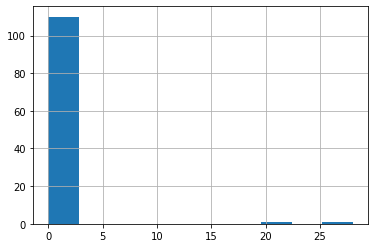

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count